In [75]:
## Imports
import requests
import os
import json
import pandas as pd
from IPython.display import display

In [76]:
## Variables
DATA_FOLDER = "./data"

INSTAGRAM_BASE_PARAMS = {
    "access_token": "####"
}
INSTAGRAM_API_USER_ID = ####
INSTAGRAM_ENDPOINT = f"https://graph.facebook.com/v16.0/{INSTAGRAM_API_USER_ID}"
INSTAGRAM_MEDIA_PER_CALL = 100
INSTAGRAM_DATA_FOLDER = f"{DATA_FOLDER}/instagram"

In [77]:
## Functions
def get_instagram_data(username):
    data_file = f"{INSTAGRAM_DATA_FOLDER}/{username}.json"
    data = {}
    if os.path.exists(data_file):
        # Get from data folder
        with open(data_file) as f:
            data = json.load(f)
    else:
        # Get from Instagram Graph API
        profile_fields = "username,website,name,ig_id,id,profile_picture_url,biography,follows_count,followers_count,media_count"
        media_fields = "id,caption,like_count,comments_count,timestamp,username,media_product_type,media_type,owner,permalink,media_url,children{media_url}"
        params = {
            **INSTAGRAM_BASE_PARAMS,
            "fields": "business_discovery.username(" + username + "){" + profile_fields + ",media.limit(" + str(INSTAGRAM_MEDIA_PER_CALL) + "){" + media_fields + "}}"
        }
        response = requests.get(INSTAGRAM_ENDPOINT, params=params).json()
        
        print(response)
        data = response["business_discovery"]
        
        # Get remaining media
        media = [ *data["media"]["data"] ]
        media_response = { **data }

        after_cursor = media_response.get("media", {}).get("paging", {}).get("cursors", {}).get("after", None)
        while after_cursor is not None:
            media_params = {
                **INSTAGRAM_BASE_PARAMS,
                "fields": "business_discovery.username(" + username + "){media.limit(" + str(INSTAGRAM_MEDIA_PER_CALL) + ").after(" + after_cursor + "){" + media_fields + "}}"
            }
            media_response = requests.get(INSTAGRAM_ENDPOINT, params=media_params).json()["business_discovery"]

            media.extend(media_response["media"]["data"])
            after_cursor = media_response.get("media", {}).get("paging", {}).get("cursors", {}).get("after", None)

        cleaned_media = []
        for m in media:
            if "children" in m:
                m["children"] = m["children"]["data"]
            cleaned_media.append(m)

        data["media"] = cleaned_media

        # Write to data folder
        os.makedirs(INSTAGRAM_DATA_FOLDER, exist_ok=True)
        with open(data_file, "w+") as f:
            json.dump(data, f, indent=4)
    
    return data

def show_instagram_user_posts(data):
    df = pd.DataFrame(data["media"]).set_index("id")
    df.drop(columns=["owner", "children"], inplace=True)
    display(df)
    
def show_instagram_user_info(data):
    avg_likes = sum([media.get("like_count", 0) for media in data["media"]]) / len(data["media"])
    avg_comments = sum([media.get("comments_count", 0) for media in data["media"]]) / len(data["media"])
    df = pd.DataFrame({
        "labels": ["Total Posts", "Average Likes", "Average Comments"],
        "values": [len(data["media"]), avg_likes, avg_comments]
    })
    display(df.plot.bar(x="labels", y="values", rot=0))

In [78]:
usernames = [
    "####",
    "####",
    "####"
]

all_data = {username: get_instagram_data(username) for username in usernames}

In [79]:
df = pd.DataFrame(all_data.values()).set_index("username")
df.drop(columns=["media"], inplace=True)
df

,website,name,ig_id,id,profile_picture_url,biography,follows_count,followers_count,media_count
username,,,,,,,,,
brigadeirobombon,https://wa.me/17867275707,BrigadeiroBombón,7519403786,17841407553589925,https://scontent.fbey5-2.fna.fbcdn.net/v/t51.2...,#brigadeirobombon,1335,2448,16
delisweets_mcbo,https://wa.me/+584146024444,Delisweets_mcbo,5329539481,17841405384436192,https://scontent.fbey5-1.fna.fbcdn.net/v/t51.2...,"""єи∂υℓzαи∂σ тυѕ мσмєитσѕ єѕρєςιαℓєѕ""\n Rᴇᴘᴏs...",3651,11591,1539
granulado_mcbo,http://wa.me/584246416641,By Hanan,38415715533,17841438505991964,https://scontent.fbey5-2.fna.fbcdn.net/v/t51.2...,Los mejores Brigadeiros Gourmet de la ciudad ❣...,384,4492,236


In [80]:
show_instagram_user_posts(all_data["brigadeirobombon"])

,caption,like_count,comments_count,timestamp,username,media_product_type,media_type,permalink,media_url
id,,,,,,,,,
17925973193330350,Brigadeiro de pistacho 💚\n\nby bydonaldbohorquez,14,0,2022-07-28T20:34:55+0000,brigadeirobombon,FEED,IMAGE,https://www.instagram.com/p/Cgkc270urye/,https://scontent.cdninstagram.com/v/t51.29350-...
17928587354417117,Coco🥥 \n\nFoto bydonaldbohorquez,12,0,2022-07-28T20:34:00+0000,brigadeirobombon,FEED,IMAGE,https://www.instagram.com/p/CgkcwOGOjfW/,https://scontent.cdninstagram.com/v/t51.29350-...
17842133972825921,Nutella🤎,17,0,2022-07-28T20:32:55+0000,brigadeirobombon,FEED,IMAGE,https://www.instagram.com/p/CgkcoVkOHlk/,https://scontent.cdninstagram.com/v/t51.29350-...
18005096227435583,"Brigadeiro de chocolate, lo confieso, mi favor...",15,0,2022-06-21T17:27:23+0000,brigadeirobombon,FEED,IMAGE,https://www.instagram.com/p/CfE1_FOlLKV/,https://scontent.cdninstagram.com/v/t51.29350-...
17899403993613437,Brigadeiro de pistacho 💚,9,3,2022-06-10T15:08:35+0000,brigadeirobombon,FEED,IMAGE,https://www.instagram.com/p/CeoRWzLu7hI/,https://scontent.cdninstagram.com/v/t51.29350-...
17921352380229846,¡CONCURSO PARA MAMÁ!\n\nParticipa y gana de nu...,94,107,2022-04-24T22:50:36+0000,brigadeirobombon,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CcwE3n_lAn4/,https://scontent.cdninstagram.com/v/t51.29350-...
17962205551562610,NaN,103,0,2022-02-14T16:34:12+0000,brigadeirobombon,REELS,VIDEO,https://www.instagram.com/reel/CZ9uz2Gl8rG/,https://scontent.cdninstagram.com/v/t50.33967-...
17865938954666938,🤎El día del amor y la amistad tiene un bombón...,79,4,2022-02-13T03:47:18+0000,brigadeirobombon,FEED,IMAGE,https://www.instagram.com/p/CZ5yYpLun8s/,https://scontent.cdninstagram.com/v/t51.29350-...
17905732891807914,Un bombón para celebrar con mamá 🌺,69,0,2021-05-10T19:21:37+0000,brigadeirobombon,FEED,IMAGE,https://www.instagram.com/p/COtDhrkl2fg/,https://scontent.cdninstagram.com/v/t51.29350-...


In [81]:
show_instagram_user_posts(all_data["delisweets_mcbo"])

,caption,like_count,comments_count,timestamp,username,media_product_type,media_type,permalink,media_url
id,,,,,,,,,
17985739412060587,MAMÁ 💕🌷🌸\n\nTodas las opciones que tenemos par...,18,0,2023-05-08T13:18:59+0000,delisweets_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/Cr-8uoFOm1S/,https://scontent.cdninstagram.com/v/t51.29350-...
17918570660708767,Piñita para Mamà💛🩷🍍🍍\n\n Desliza👆 para que vea...,30,4,2023-05-07T23:44:19+0000,delisweets_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/Cr9ff1Cu9oB/,https://scontent.cdninstagram.com/v/t51.29350-...
17966491211245099,Mini Bundt cake para Mamá 💕🌸\n\nPuedes sorpren...,23,0,2023-05-06T21:18:24+0000,delisweets_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/Cr6qALROJRT/,https://scontent.cdninstagram.com/v/t51.29350-...
18090555175333729,Nuestra 3 opción para MAMÁ 💕🌸\n\nSiempre lo me...,37,6,2023-05-05T23:31:14+0000,delisweets_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/Cr4UaRbu-cz/,https://scontent.cdninstagram.com/v/t51.29350-...
17969360402463903,MAMÁ 💕💕🌸\nSeguimos mostrándoles las opciones h...,29,6,2023-05-04T21:54:51+0000,delisweets_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/Cr1klYxO7HE/,https://scontent.cdninstagram.com/v/t51.29350-...
...,...,...,...,...,...,...,...,...,...
17877159385012648,Drip cake 😍\n#me encantan los drip cakes # del...,13,1,2017-04-15T03:09:20+0000,delisweets_mcbo,FEED,IMAGE,https://www.instagram.com/p/BS4_AMJjx68/,https://scontent.cdninstagram.com/v/t51.2885-1...
17854416790155837,Cake pops,16,1,2017-04-15T03:05:40+0000,delisweets_mcbo,FEED,IMAGE,https://www.instagram.com/p/BS4-lUIDfPK/,https://scontent.cdninstagram.com/v/t51.2885-1...
17869058350079047,Mini cakes 😍,24,2,2017-04-15T03:02:33+0000,delisweets_mcbo,FEED,IMAGE,https://www.instagram.com/p/BS4-OfYjco_/,https://scontent.cdninstagram.com/v/t51.2885-1...


In [82]:
show_instagram_user_posts(all_data["granulado_mcbo"])

,caption,like_count,comments_count,timestamp,username,media_product_type,media_type,permalink,media_url
id,,,,,,,,,
18017482780562598,Best Mom 🌸\n\nQue mejor manera de sorprender a...,22.0,5,2023-05-12T17:38:18+0000,granulado_mcbo,REELS,VIDEO,https://www.instagram.com/reel/CsJtXdQukIH/,NaN
18220938805169168,Que tal esta Cajita de bombones de fresa para ...,NaN,2,2023-05-08T22:31:32+0000,granulado_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/Cr_79juuGr4/,https://scontent.cdninstagram.com/v/t51.29350-...
18246243514080315,Para ti Mamá 🌸\n\nTe presentamos nuestra cajit...,NaN,3,2023-05-05T23:26:28+0000,granulado_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/Cr4T3X9u9r1/,https://scontent.cdninstagram.com/v/t51.29350-...
17979645017171644,Feliz día del trabajador a toda aquella person...,145.0,24,2023-05-01T16:47:31+0000,granulado_mcbo,REELS,VIDEO,https://www.instagram.com/reel/CrtS_1csuns/,https://scontent.cdninstagram.com/o1/v/t16/f1/...
17975176586329879,Jueves de #tbt🔙📸 \n\nDe las cosas que más amo ...,84.0,9,2023-04-27T23:33:05+0000,granulado_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CrjuQvruMk3/,https://scontent.cdninstagram.com/v/t51.29350-...
...,...,...,...,...,...,...,...,...,...
17952765199347232,"CHURROS, brigadeiro de chocolate blanco envuel...",55.0,6,2020-07-10T02:51:20+0000,granulado_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CCcgikgAmYJ/,https://scontent.cdninstagram.com/v/t51.29350-...
17900593414503871,"Brigadeiro de coco tostado, para los amantes d...",52.0,1,2020-07-10T02:48:09+0000,granulado_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CCcgLN0AscC/,https://scontent.cdninstagram.com/v/t51.29350-...
18148000552006375,"Brigadeiro napolitano envuelto en azúcar, una ...",54.0,1,2020-07-10T02:46:27+0000,granulado_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CCcf-wHAJqF/,https://scontent.cdninstagram.com/v/t51.29350-...


<AxesSubplot:xlabel='labels'>

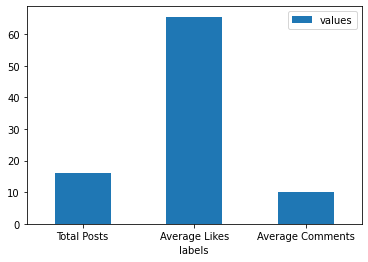

In [83]:
show_instagram_user_info(all_data["brigadeirobombon"])

<AxesSubplot:xlabel='labels'>

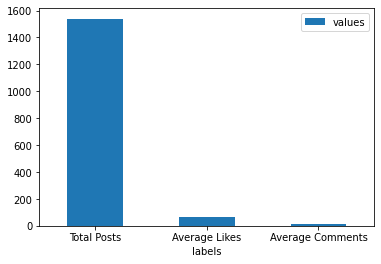

In [84]:
show_instagram_user_info(all_data["delisweets_mcbo"])

<AxesSubplot:xlabel='labels'>

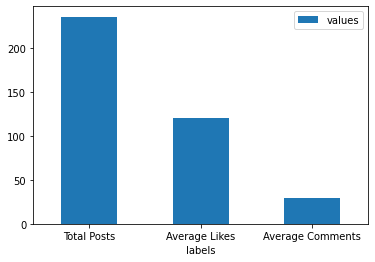

In [85]:
show_instagram_user_info(all_data["granulado_mcbo"])